In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from model import KeywordSpottingModel
from data_loader import load_speech_commands_dataset, TFDatasetAdapter
from utils import set_memory_GB,print_model_size, log_to_file, plot_learning_curves
from augmentations import add_time_shift_noise_and_align, add_noise
from train import trainig_loop






/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [2]:
torch.cuda.is_available()

True

In [3]:
set_memory_GB(1)

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [4]:
train_ds, val_ds, test_ds, info = load_speech_commands_dataset()

2024-08-26 13:18:56.004087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-26 13:18:56.010246: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 13:18:56.023295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 13:18:56.044166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 13:18:56.050300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attemptin

In [5]:
# maintain seed for repructablity
np.seed = 42
# tf.random.set_seed(42)
torch.manual_seed(0)

In [6]:
label_names = info.features['label'].names
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [7]:
augmentations = [
    lambda x: add_time_shift_noise_and_align(x),
    lambda x: add_noise(x,noise_level = 0.01)
]

In [85]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 40
n_fft = 640
hop_length = 320
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter(train_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations)
pytorch_val_dataset = TFDatasetAdapter(val_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f45eb3bed40>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 

In [86]:
# Create a DataLoader to feed the data into the model
batch_size = 32
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,prefetch_factor=2)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

In [87]:
for audio, label in train_loader:
    print(audio.shape, label.shape)
    break


torch.Size([32, 40, 51]) torch.Size([32])


# Compute model size

In [93]:
# Initialize model, loss function, and optimizer
input_dim = 40  # Number of MFCC features
d_model = 51  # Number of frames
d_state = 16
d_conv = 4
expand = 2

model = KeywordSpottingModel(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=info.features['label'].names).to("cuda")


In [94]:

# # Register custom operation
inputs = torch.randn(batch_size, input_dim, d_model).to("cuda")
        
# macs, params, ret_layer_info = thop.profile(model, inputs=(torch.randn(batch_size, 13, 101).to("cuda"),)
# ,custom_ops={Mamba: calculate_MAMBA_flops},report_missing=True, ret_layer_info=True)
# print()
# print(f"MACs: {macs} Which are {macs/1e9} Giga-MACs, Params: {params}")

print_model_size(model,input_size=inputs)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'model.KeywordSpottingModel'>. Treat it as zero Macs and zero Params.

MACs: 77519592.0 Which are 0.077519592 Giga-MACs, Params: 46983.0

Layer-wise information:
Layer: proj
Total FLOPs: 3329280.0, Total Params: 2091.0

Layer: mamba_layers
Total FLOPs: 73504872.0, Total Params: 44064.0

Layer: batch_norms
Total FLOPs: 66585

(77519592.0, 46983.0)

# Training loop

# With L2 regulariztion AND Droput layer

In [95]:
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(model.parameters(), lr=0.0024, weight_decay=1e-3) # weight_decay for L2 regulariztopn

from torch_optimizer import Lookahead

optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam


In [96]:
import torch.optim as optim
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [97]:
num_epochs = 100
train_accuracies, val_accuracies, train_losses, val_losses = trainig_loop(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:11<00:00, 20.31it/s]

Epoch 1/100, Training Loss: 0.9850701330821254, Training Accuracy: 71.28907392031435%


Validation Loss: 0.5809547232487534, Validation Accuracy: 81.80558305286083%
Learning rate after epoch 1: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:08<00:00, 20.79it/s]

Epoch 2/100, Training Loss: 0.5743805381451659, Training Accuracy: 81.3485984259335%


Validation Loss: 0.45982561366561847, Validation Accuracy: 85.49792120372203%
Learning rate after epoch 2: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:07<00:00, 20.97it/s]

Epoch 3/100, Training Loss: 0.5025593407014493, Training Accuracy: 83.80910058355066%


Validation Loss: 0.4417612211708027, Validation Accuracy: 85.83448822015443%
Learning rate after epoch 3: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:11<00:00, 20.29it/s]

Epoch 4/100, Training Loss: 0.46253233241022546, Training Accuracy: 85.08028206897359%


Validation Loss: 0.42301989339669294, Validation Accuracy: 86.89368441892695%
Learning rate after epoch 4: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:07<00:00, 20.97it/s]

Epoch 5/100, Training Loss: 0.43712460430282535, Training Accuracy: 86.02051198091473%


Validation Loss: 0.4002816304328698, Validation Accuracy: 87.22035240546427%
Learning rate after epoch 5: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:09<00:00, 20.61it/s]

Epoch 6/100, Training Loss: 0.41856118770482786, Training Accuracy: 86.64616248201986%


Validation Loss: 0.425022219272354, Validation Accuracy: 87.26984755493962%
Learning rate after epoch 6: [0.0024]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:03<00:00, 21.59it/s]

Epoch 7/100, Training Loss: 0.40503384730107234, Training Accuracy: 87.11978575855738%


Validation Loss: 0.3674754885414356, Validation Accuracy: 88.55672144129875%
Learning rate after epoch 7: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:12<00:00, 20.13it/s]

Epoch 8/100, Training Loss: 0.3924424022051488, Training Accuracy: 87.41214580580277%


Validation Loss: 0.36438268114211436, Validation Accuracy: 88.53692338150861%
Learning rate after epoch 8: [0.0024]
Best model saved


 13%|████████▉                                                          | 356/2673 [00:19<03:09, 12.20it/s]

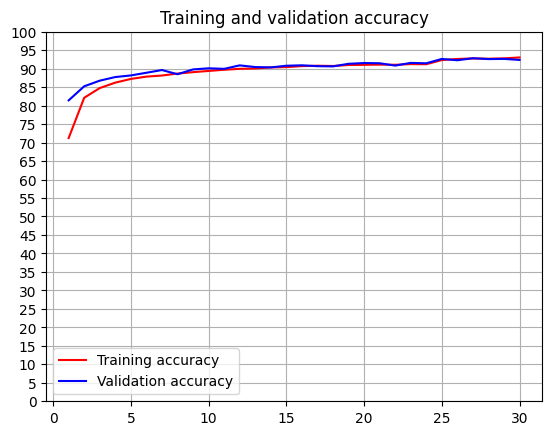

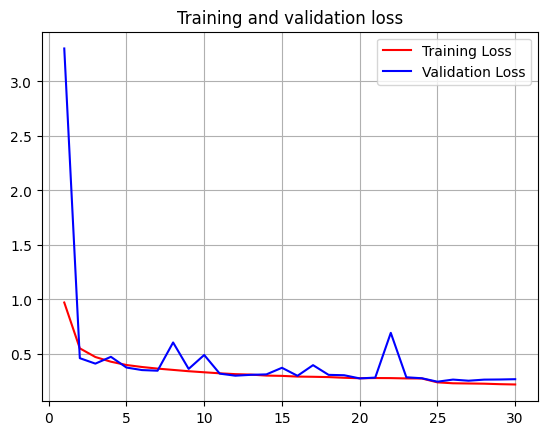

In [ ]:
# Plot the learning curves
plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)

In [16]:
# calc weights for unbalanced dataset
from utils import compute_label_distribution
label_distribution = compute_label_distribution(train_ds,title="")
# Convert label counts to a list of counts in the order of label indices
counts_list = [label_distribution[i] for i in sorted(label_distribution.keys())]
# Compute total number of samples
total_samples = sum(counts_list)

# Compute the number of classes
num_classes = len(counts_list)

# Calculate class weights
class_weights = [total_samples / (num_classes * count) for count in counts_list]




In [45]:
class_weights_normalized = class_weights / np.sum(class_weights)  # Normalize class weights
# print(class_weights_normalized)
class_weights_tensor = torch.tensor(class_weights_normalized).to("cuda")
# fine tune the model with balanced dataset
max_samples = int(len(pytorch_train_dataset) * min(class_weights_normalized) *len(class_weights_normalized))
sampler = torch.utils.data.WeightedRandomSampler(
    weights=class_weights_tensor,
    num_samples=len(pytorch_train_dataset),
    replacement=True
)
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size,num_workers=4,prefetch_factor=2,sampler=sampler)


[0.06692527 0.06752859 0.06906283 0.0670108  0.07062081 0.06796624
 0.0694746  0.06742006 0.07114783 0.0649764  0.31398774 0.00387883]
1990


In [50]:
model = KeywordSpottingModel(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=info.features['label'].names).to("cuda")
model.load_state_dict(torch.load("best_model.pth"),strict=False)
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-6) # weight_decay for L2 regulariztopn
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

/tmp/ipykernel_1636235/2969890603.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"),strict=False)


In [51]:
num_epochs = 10
train_accuracies, val_accuracies, train_losses, val_losses = trainig_loop(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, save_best_model=False)

100%|██████████████████████████████████████████████████████████████████| 2673/2673 [01:17<00:00, 34.30it/s]

Epoch 1/10, Training Loss: 0.20444942188800758, Training Accuracy: 93.26987171241127%


Validation Loss: 0.44269533135892847, Validation Accuracy: 87.47772718273609%
Learning rate after epoch 1: [1e-05]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [01:15<00:00, 35.48it/s]

Epoch 2/10, Training Loss: 0.029963346237485363, Training Accuracy: 99.70062331162073%


Validation Loss: 0.4592379462327572, Validation Accuracy: 87.08176598693328%
Learning rate after epoch 2: [1e-05]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [01:10<00:00, 38.15it/s]

Epoch 3/10, Training Loss: 0.011930592310226572, Training Accuracy: 99.92866414847212%


Validation Loss: 0.5469744549946317, Validation Accuracy: 85.29004157592556%
Learning rate after epoch 3: [1e-05]


  1%|▋                                                                   | 27/2673 [00:01<02:26, 18.07it/s]


KeyboardInterrupt: 

In [52]:
# load test data
pytorch_test_dataset = TFDatasetAdapter(test_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)
test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)
# model.load_state_dict(torch.load("best_model.pth"),strict=False)
# Evaluate the model on the test set
accuracy = 0
total = 0
model.eval()

with torch.no_grad():
    for audio, labels in test_loader:
        audio, labels = audio.to("cuda"), labels.to("cuda")
        outputs = model(audio)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * accuracy / total}%')


Test Accuracy: 79.36605316973416%


In [ ]:
def compute_inference_GPU_mem(model, input):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    m0 = torch.cuda.max_memory_allocated()
    model(input)
    m1 = torch.cuda.max_memory_allocated()
    # Compute total memory used
    total_memory = (m1 - m0) / 1e6  # Convert to MB
    
    return total_memory

In [ ]:
import pandas as pd
# from utils import compute_inference_GPU_mem
#save model size(macs, params) and accuracy
macs, params = print_model_size(model,input_size=inputs)
macs = macs/1e9
accuracy = max(val_accuracies)
data = {'Model': ['KeywordSpottingModel'], 'GMACs': [macs], 'Params': [params], 'Accuracy': [accuracy]}
model_config = {'input_dim': input_dim, 'd_model': d_model, 'd_state': d_state, 'd_conv': d_conv, 'expand': expand}
data.update(model_config)
inf_GPU_mem = compute_inference_GPU_mem(model, input=torch.randn(1, input_dim, d_model).to("cuda"))
#inference macs and params
inf_macs, inf_params = print_model_size(model,input_size=torch.randn(1, input_dim, d_model).to("cuda"))
inference_data = {'Inference CUDA Mem in MB': [inf_GPU_mem], 'Inference GMACs': [inf_macs/1e9], 'Inference Params': [inf_params]}
data.update(inference_data)
df = pd.DataFrame(data, index=[0])
df.to_csv('results.csv', mode='a', header=False)


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'model.KeywordSpottingModel'>. Treat it as zero Macs and zero Params.

MACs: 77519592.0 Which are 0.077519592 Giga-MACs, Params: 46983.0

Layer-wise information:
Layer: proj
Total FLOPs: 3329280.0, Total Params: 2091.0

Layer: mamba_layers
Total FLOPs: 73504872.0, Total Params: 44064.0

Layer: batch_norms
Total FLOPs: 66585

In [ ]:
import pandas as pd

results_file = pd.read_csv('results.csv')

memory_usage = []

for index, row in results_file.iterrows():
    
    input_dim = row['input_dim']
    d_model = row['d_model']
    d_state = row['d_state']
    d_conv = row['d_conv']
    expand = row['expand']

    model = KeywordSpottingModel(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=info.features['label'].names).to("cuda")
    input = torch.randn(1, input_dim, d_model).to("cuda")

    # inf_GPU_mem = compute_inference_GPU_mem(model, input=torch.randn(1, input_dim, d_model).to("cuda"))
    # #inference macs and params
    inf_macs, inf_params = print_model_size(model,input_size=torch.randn(1, input_dim, d_model).to("cuda"))
    inference_data = {'Inference GMACs': [inf_macs/1e9], 'Inference Params': [inf_params]}
    print(inference_data)
# add inference data to the DataFrame
    results_file.at[index, 'Inference GMACs'] = inference_data['Inference GMACs'][0]
    results_file.at[index, 'Inference Params'] = inference_data['Inference Params'][0]

# Save the updated DataFrame back to the CSV file
results_file.to_csv('results.csv', index=False)
    








[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'model.KeywordSpottingModel'>. Treat it as zero Macs and zero Params.

MACs: 30207585.0 Which are 0.030207585 Giga-MACs, Params: 179186.0

Layer-wise information:
Layer: proj
Total FLOPs: 132613.0, Total Params: 1414.0

Layer: mamba_layers
Total FLOPs: 29992152.0, Total Params: 176144.0

Layer: batch_norms
Total FLOPs: 8160